# Predictive Modeling on IMDB Movie Data

In [1]:
from user_defined_functions.eda_functions import *
from user_defined_functions.modeling_functions import *

# display plots in notebook
%matplotlib inline
sns.set(style="whitegrid", color_codes=True)

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 14,
         'axes.titlesize': 20,
         'xtick.labelsize': 14,
         'ytick.labelsize': 14}
plt.rcParams.update(params)

/Users/jinxin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


### 1. Baseline Models

#### 1.1 Outline
In this part, we will start with some data preprocessing work including missing value imputation and feature scaling. Then we will build the following models:
1. Baseline models that only include the top 3 features that are mostly correlated with **imdb_score**. These three features are **num_voted_users**, **num_critic_for_reviews**, and **num_user_for_reviews**. Linear regression and random forest will be used here
2. Models with all numerical features. Linear regression and random forest will be used here. Also we will remove some redundant features based on **feature importance** from random forest
3. Once we have a winner from step 1 and 2, we will conclude the **Baseline Models** section with alternative machine learning algorithms e.g. XGBoost to check if the model performance is different

In [2]:
# train/test set split. Note that in the train_test_split function, the
# random_state is set to 42. This ensures that we are dealing with the same data
# across EDA and modeling
imdb = pd.read_csv('movie_metadata.csv.zip', compression='zip', delimiter=',')
data, target = imdb.drop('imdb_score', axis=1), imdb['imdb_score']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), \
                                   y_train.reset_index(drop=True), y_test.reset_index(drop=True)
data_with_y = pd.concat([y_train, X_train], axis=1)

In [3]:
corr_matrix = data_with_y.corr()
corr_matrix['imdb_score'].sort_values(ascending=False)

imdb_score                   1.000000
num_voted_users              0.413193
num_critic_for_reviews       0.306509
num_user_for_reviews         0.287095
duration                     0.261398
movie_facebook_likes         0.250373
gross                        0.194405
director_facebook_likes      0.170634
cast_total_facebook_likes    0.074107
actor_1_facebook_likes       0.068349
actor_2_facebook_likes       0.067940
aspect_ratio                 0.052711
actor_3_facebook_likes       0.042549
budget                       0.042236
facenumber_in_poster        -0.064741
title_year                  -0.209739
Name: imdb_score, dtype: float64

first things first, let's create the training sets for step 1 and step 2 mentioned in the outline

In [4]:
# training data with only 3 features that are highly correlated with "imdb_score"
X_simple_numeric = X_train[[ "num_voted_users", "num_critic_for_reviews", "num_user_for_reviews"]]

# training data with all continuous features
X_numeric = X_train.drop(['color',
                         'director_name',
                         'actor_2_name',
                         'genres',
                         'actor_1_name',
                         'movie_title',
                         'actor_3_name',
                         'plot_keywords',
                         'movie_imdb_link',
                         'language',
                         'country',
                         'content_rating',
                         'title_year'  # notice that in EDA, we treated year as if it was continuous. 
                                       # However, in practice, it is often treated as a categorical feature                         
                         ], axis=1)

#### 1.2 Missing Value Imputation

As seen in our exploratory data analysis, the majority of features have missing values. Since Scikit-learn's machine learning algorithms doesn't accept missing value, we need to fill the empty holes. Let's use column median to impute the missing data. This often proves to be a valid method.

In [5]:
imputer = Imputer(strategy="median")
imputer.fit(X_simple_numeric)

# compare if the imputer's result is correct
print imputer.statistics_
print X_simple_numeric.median().values

# transform on the whole dataframe and conver the data to a dataframe
X_simple_impute = imputer.transform(X_simple_numeric)
X_simple_impute_df = pd.DataFrame(X_simple_impute, columns=X_simple_numeric.columns)
X_simple_impute_df.head(5)

[ 34460.    110.    157.]
[ 34460.    110.    157.]


,num_voted_users,num_critic_for_reviews,num_user_for_reviews
0,227072.0,325.0,560.0
1,15315.0,65.0,117.0
2,58871.0,212.0,156.0
3,59507.0,231.0,232.0
4,206776.0,153.0,1248.0


#### 1.3 Feature Scaling

When dealing with continuous features, we easily come across the situation where the scale of each feature is different. For imdb data, we have **duration** that's in minutes and **gross** that's in millions of dollars. Therefore, to make sure that large-scale features don't dominate other feature, we need to perform feature scaling. This is especially important for linear regression since large-scale features can easily dominate other features. For non-parametric models such as random forest, this is less of an issue.

In [6]:
scaler = StandardScaler()
X_simple_scale = scaler.fit_transform(X_simple_impute)
X_simple_scale_df = pd.DataFrame(X_simple_scale, columns=X_simple_numeric.columns)
X_simple_scale_df.head(5)

,num_voted_users,num_critic_for_reviews,num_user_for_reviews
0,1.078941,1.547766,0.768493
1,-0.504505,-0.627770,-0.412095
2,-0.178808,0.602245,-0.308161
3,-0.174052,0.761226,-0.105622
4,0.927175,0.108565,2.602003


#### 1.4 Data Preprocessing Pipeline

From subsetting features, imputing missing value, to scaling features, it'd be inefficient to use similar code repetitively for each model. Therefore, let's use Scikit-learn's pipeline to automate the process. Eventually, after selecting the best machine learning algorithm, we can even incorporate it into the pipeline.

Since Scikit-learn doesn't have a class to subset features, we can define one. (see modeling.py)

We have two pipelines for:
1. Model with top 3 most correlated features with **imdb_score** 
2. Model with all numerical features

In [7]:
simple_num_features = ['num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews']

full_num_features = ['num_critic_for_reviews', 'duration', 'director_facebook_likes',
                     'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
                     'num_voted_users', 'cast_total_facebook_likes',
                     'facenumber_in_poster', 'num_user_for_reviews', 'budget',
                     'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes']

simple_num_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(simple_num_features)),
        ('imputer', Imputer(strategy="median")),
        ('feature_scaler', StandardScaler()),
    ])

full_num_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(full_num_features)),
        ('imputer', Imputer(strategy="median")),
        ('feature_scaler', StandardScaler()),
    ])

X_simple_numeric = simple_num_pipeline.fit_transform(X_train)
X_full_numeric = full_num_pipeline.fit_transform(X_train)

#### 1.5 Baseline Model

After preprocessing the data, let's use linear regression and random forest to train the data. Also, let's use RMSE to check the model performance.

RMSE is short for root mean square error, it's defined as $\sqrt{(y_{response} - y_{predict})^2}$.

Alternatively, we can use MAE (mean absolute error) to evaluate a model. MAE is less affected by outliers in the data, but we have already scaled the feature to mitigate the effect of outliers, we can stick to RMSE for the rest modeling process.

In [8]:
linear_simple_reg, linear_simple_rmse= train_model(X_simple_numeric, y_train, LinearRegression())
linear_full_reg, linear_full_rmse= train_model(X_full_numeric, y_train, LinearRegression())
forest_simple_reg, forest_simple_rmse = train_model(X_simple_numeric, y_train, RandomForestRegressor(random_state=0))
forest_full_reg, forest_full_rmse = train_model(X_full_numeric, y_train, RandomForestRegressor(random_state=0))

Indicated from the results below, apparenetly, we have a winner here. Random forest with full numerical features has the lowest training RMSE.

In [9]:
print "Linear regression with 3 features RMSE: " + str(linear_simple_rmse)
print "Linear regression with full continuous features RMSE: " + str(linear_full_rmse)
print "Random forest with 3 features RMSE: " + str(forest_simple_rmse)
print "Random forest with full continuous features RMSE: " + str(forest_full_rmse)

Linear regression with 3 features RMSE: 1.00741852284
Linear regression with full continuous features RMSE: 0.971061330301
Random forest with 3 features RMSE: 0.442283696671
Random forest with full continuous features RMSE: 0.355091342023


We just made predictions using our whole training set and computed RMSE. But this isn't very helpful because the model is tailored for the training data. It's hard to tell whether the model will generalize well on unseen test data. 

As mentioned earlier, we can only use test set once, so how do we further check if random forest is truly better? The answer is to use **cross validation**, especially **k-fold cross validation**.

K-fold cross validation is to partition the dataset into K random parts. Iterate through each part, training on the rest and testing on that one. Average the performance metric across all iterations for the cross-validation score.

Now let's use a 10-fold cross validation on each of the four models we have trained so far.

From results below, we can see the RMSE is higher than we just got. This makes sense because in k-fold cross validation each fold is treated as if it was a unseen test set so we can avoid over fitting. It should be noted that, when the dataset is really large, k-fold validation can be very slow. 10-fold validation means we train the model 10 times. In this case, we can usually pick a smaller k, for example 3 or 5.

Based on the cross validation results we can confirm that random forest with all numerical features outperforms others.

In [10]:
print "Linear regression with 3 features RMSE: "
cross_validation_rmse(linear_simple_reg, X_simple_numeric, y_train),
print "Linear regression with full continuous features RMSE: "
cross_validation_rmse(linear_full_reg, X_full_numeric, y_train),

print "Random forest with 3 features RMSE: "
cross_validation_rmse(forest_simple_reg, X_simple_numeric, y_train),

print "Random forest with with full continuous fueatures RMSE: "
cross_validation_rmse(forest_full_reg, X_full_numeric, y_train)

Linear regression with 3 features RMSE: 
('RMSE from 10-fold cross validation:', array([ 0.95337439,  0.99912604,  0.97920653,  1.04653987,  1.0157408 ,
        1.0096799 ,  0.98469662,  1.06996258,  1.01663047,  1.00540754]))
('RMSE Mean:', 1.008036472196371)
('RMSE Standard deviation:', 0.031469721802933087)

Linear regression with full continuous features RMSE: 
('RMSE from 10-fold cross validation:', array([ 0.9707842 ,  0.96884803,  0.94382333,  1.01595981,  0.98159111,
        0.96335423,  0.95880617,  1.03339611,  0.97682137,  0.95426897]))
('RMSE Mean:', 0.97676533130944576)
('RMSE Standard deviation:', 0.026379257754898616)

Random forest with 3 features RMSE: 
('RMSE from 10-fold cross validation:', array([ 1.01624698,  1.07340173,  0.998314  ,  1.05879491,  1.03846852,
        1.07984582,  1.05840612,  1.07913783,  1.07025507,  1.06305601]))
('RMSE Mean:', 1.053592700271399)
('RMSE Standard deviation:', 0.026135755196379323)

Random forest with with full continuous fueatures

#### 1.6 Feature Importance Analysis

For ensemble methods such as random forest, we can extract feature importance. It helps us visualize which features are more predictive. Combined with domain knowledge and understanding of the data, we might be able to remove some redundant features without harming the model performance much.

**Summary: ** Based on the feature importance plot below, we can easily remove two least important featues **facenumber_in_poster** and **aspect_ratio**. All **actor_facebook_likes** features are not very important either and their correaltion with **movie_score** is low. Let's remove them as well.

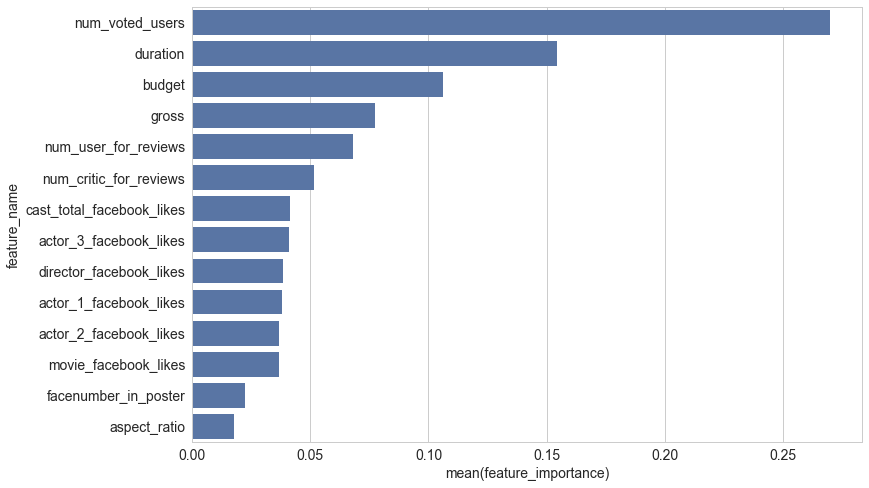

In [11]:
rf_feature_importance = forest_full_reg.feature_importances_
feature_importance_plot(rf_feature_importance, full_num_features)

From the results below, the RMSE dropped from 0.8451 to 0.8419 after removing redudant features. Next, let's try out a few other machine learning algorithms before feature engineering.

In [12]:
reduced_num_features = ['num_critic_for_reviews', 'duration', 'director_facebook_likes',
                        'gross', 'num_voted_users', 'cast_total_facebook_likes',
                        'num_user_for_reviews', 'budget']
reduced_num_pipeline = Pipeline([
        ('feature_selector', FeatureSelector(reduced_num_features)),
        ('imputer', Imputer(strategy="median")),
        ('feature_scaler', StandardScaler()),
    ])

X_reduced_numeric = reduced_num_pipeline.fit_transform(X_train)
forest_reduced_reg, forest_reduced_rmse = train_model(X_reduced_numeric, y_train, RandomForestRegressor(random_state=0))

print "Random forest with full continuous features RMSE: "
cross_validation_rmse(forest_reduced_reg, X_reduced_numeric, y_train)

Random forest with full continuous features RMSE: 
('RMSE from 10-fold cross validation:', array([ 0.7532351 ,  0.8806734 ,  0.81253515,  0.85821713,  0.91930144,
        0.82255774,  0.79162458,  0.89496732,  0.81334771,  0.87235712]))
('RMSE Mean:', 0.84188166892814209)
('RMSE Standard deviation:', 0.048933745135596167)



#### 1.7 Alternative Methods

I have selected the following algorithms: gradient boosting from Scikit-learn, Keras, and XGBoost. I haven't done any hyperparamter-tuning here since the default parameter value is often good enough for model comparison.

After comparing all three algorithms, I decided to use XGBoost from now on for its better performance.

##### 1.71 Gradient Boosting

Gradient boosting further reduced the cross validation RMSE from 0.8419 to 0.8144.

In [13]:
gradient_reduced_reg, gradient_reduced_rmse = train_model(X_reduced_numeric, y_train, GradientBoostingRegressor(random_state=0))
cross_validation_rmse(gradient_reduced_reg, X_reduced_numeric, y_train)

('RMSE from 10-fold cross validation:', array([ 0.7338963 ,  0.84737523,  0.77850277,  0.85833261,  0.83663206,
        0.81081576,  0.76596801,  0.86791741,  0.81318195,  0.83133303]))
('RMSE Mean:', 0.81439551003206301)
('RMSE Standard deviation:', 0.040978030434183514)



##### 1.72 Keras
Neural networks are usually applied to image and genome data, but we can surely try it out on movie data. Here I used a one-hidden-layer neural network because the data set is quite small.

From Keras, the MSE on validation set is 0.7684 the RMSE (square root of MSE) is 0.8765. It doesn't outperform gradient boosting.

In [14]:
model = Sequential()

# the hidden layer
model.add(Dense(500, input_dim=X_reduced_numeric.shape[1], activation='relu'))

# the final layer
model.add(Dense(1))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_reduced_numeric, y_train, validation_split=0.1, epochs=50, batch_size=30, verbose=2)

Train on 3630 samples, validate on 404 samples
Epoch 1/50
0s - loss: 14.7725 - val_loss: 3.4055
Epoch 2/50
0s - loss: 2.6822 - val_loss: 1.5313
Epoch 3/50
0s - loss: 1.3626 - val_loss: 1.1390
Epoch 4/50
0s - loss: 1.0437 - val_loss: 1.0989
Epoch 5/50
0s - loss: 0.9498 - val_loss: 1.0183
Epoch 6/50
0s - loss: 0.8847 - val_loss: 0.9421
Epoch 7/50
0s - loss: 0.8444 - val_loss: 0.9358
Epoch 8/50
0s - loss: 0.8236 - val_loss: 0.9261
Epoch 9/50
0s - loss: 0.8067 - val_loss: 0.8703
Epoch 10/50
0s - loss: 0.7903 - val_loss: 0.8451
Epoch 11/50
0s - loss: 0.7816 - val_loss: 0.8309
Epoch 12/50
0s - loss: 0.7676 - val_loss: 0.8579
Epoch 13/50
0s - loss: 0.7771 - val_loss: 0.9025
Epoch 14/50
0s - loss: 0.7761 - val_loss: 0.8611
Epoch 15/50
0s - loss: 0.7712 - val_loss: 0.8228
Epoch 16/50
0s - loss: 0.7766 - val_loss: 0.8241
Epoch 17/50
0s - loss: 0.7562 - val_loss: 0.8083
Epoch 18/50
0s - loss: 0.7479 - val_loss: 0.7763
Epoch 19/50
0s - loss: 0.7473 - val_loss: 0.7999
Epoch 20/50
0s - loss: 0.7487 

##### 1.73 XGBoost

XGBoost further reduced the RMSE from 0.8143 (gradient boosting) to 0.8106. Therefore, let's use XGBoost for the rest modeling process.

In [15]:
xgboost_reduced_reg, xgboost_reduced_rmse = train_model(X_reduced_numeric, y_train, XGBRegressor())
cross_validation_rmse(xgboost_reduced_reg, X_reduced_numeric, y_train)

('RMSE from 10-fold cross validation:', array([ 0.7313973 ,  0.85113154,  0.77156097,  0.85197099,  0.82899475,
        0.81184401,  0.76275801,  0.85934375,  0.80852319,  0.82855624]))
('RMSE Mean:', 0.81060807564630843)
('RMSE Standard deviation:', 0.040599188136697703)



### 2. Feature Engineering

In this section, we will engineer some new numerical and categorical features. Exploratory data analysis is going to be helpful here.

#### 2.1 Continuous Features

As we discussed earlier, the **budget** of some movies is not expressed in US dollars. Let's turn these values into None and impute them with budget median of the rest movies later on.

In [16]:
data_with_y['budget'] = data_with_y['budget'].apply(budget_adjust)

When we looked at the average rating of **directors** and **actor 1** in the exploratory data analysis, we saw that the rating is very different across people. So let's create two new average rating features based on **director_name** and **actor_1_name**.

In [17]:
director_avg_df = avg_rating(data_with_y, 'director_name')
actor1_avg_df = avg_rating(data_with_y, 'actor_1_name')

data_with_y = pd.merge(data_with_y, director_avg_df, how='left', on=['director_name'])
data_with_y = pd.merge(data_with_y, actor1_avg_df, how='left', on=['actor_1_name'])

Indeed, the correlation between the new features and **imdb_score** is very high.

In [18]:
corr_matrix = data_with_y.corr()
corr_matrix['imdb_score'].sort_values(ascending=False)

imdb_score                   1.000000
avg_director_name_score      0.868420
avg_actor_1_name_score       0.775038
num_voted_users              0.413193
num_critic_for_reviews       0.306509
num_user_for_reviews         0.287095
duration                     0.261398
movie_facebook_likes         0.250373
gross                        0.194405
director_facebook_likes      0.170634
cast_total_facebook_likes    0.074107
actor_1_facebook_likes       0.068349
actor_2_facebook_likes       0.067940
aspect_ratio                 0.052711
actor_3_facebook_likes       0.042549
budget                       0.039094
facenumber_in_poster        -0.064741
title_year                  -0.209739
Name: imdb_score, dtype: float64

In [19]:
data_with_y.head(5)

,imdb_score,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,aspect_ratio,movie_facebook_likes,avg_director_name_score,avg_actor_1_name_score
0,6.9,Color,Albert Hughes,325.0,118.0,117.0,10000.0,Mila Kunis,18000.0,94822707.0,...,English,USA,R,80000000.0,2010.0,15000.0,2.35,20000,6.850000,7.023810
1,5.0,Color,David Wain,65.0,96.0,136.0,139.0,Ken Marino,4000.0,766487.0,...,English,USA,R,5250000.0,2007.0,543.0,1.85,915,5.800000,5.833333
2,6.5,Color,Roger Michell,212.0,107.0,50.0,58.0,Patti D'Arbanville,293.0,30993544.0,...,English,USA,PG-13,40000000.0,2010.0,117.0,2.35,0,6.666667,6.500000
3,7.8,Color,Paul Verhoeven,231.0,145.0,719.0,104.0,Sebastian Koch,2000.0,4398392.0,...,Dutch,Netherlands,R,21000000.0,2006.0,380.0,2.35,0,6.775000,7.400000
4,6.9,Color,Cameron Crowe,153.0,141.0,488.0,509.0,Ivana Milicevic,10000.0,100614858.0,...,English,USA,R,68000000.0,2001.0,834.0,1.85,0,6.580000,7.114286


#### 2.2 Categorical Features

In this section, we will engineer the following new features:
1. **year_category**: in the orginal dataset, we have a **title_year** feature. As can be seen from the scatter plot below, movies produced before 1980 have higher ratings than afterward. Therefore, **year_category** feature will have two unique values: **before_1980** and **after_1980**
2. **content_rating**: the values are "PG_13", "R", "G", etc. From our earlier exploratory data analysis, this feature might be helpful
3. **num_genres**: in the dataset, we have a **genres** feature, some movies only belong to one or two genres while others belong to multiplie. We can create a **num_genres** feature that indicates the number of genres a movie belong to. **num_genres** will be a numerical feature

##### 2.21 Year Category

The scatter plot below shows that movies produced before 1980 have higher ratings than after.

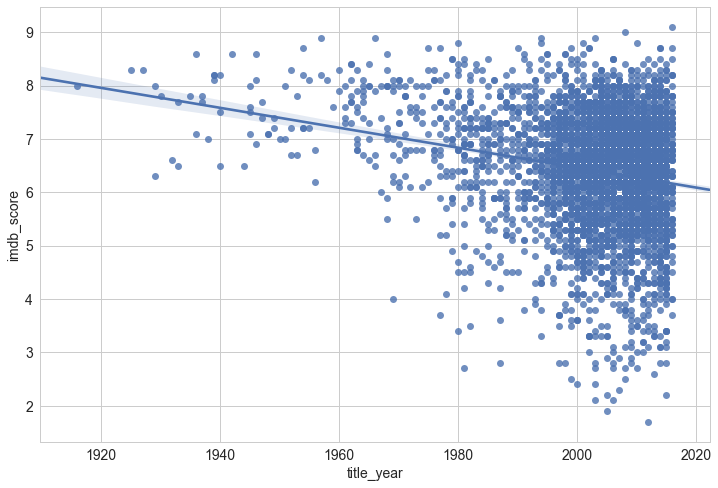

In [20]:
sns.regplot(x='title_year', y='imdb_score', data=data_with_y)

After grouping **title_year** into two categories **before_1980** and **after_1980**, the distribution and the mean between two categories are indeed very different.

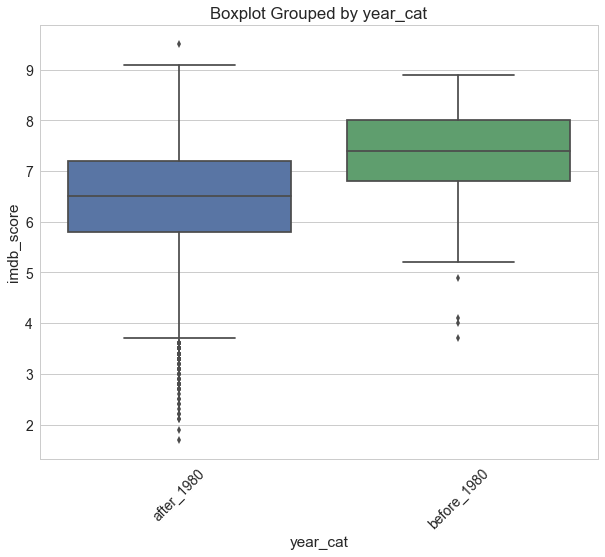

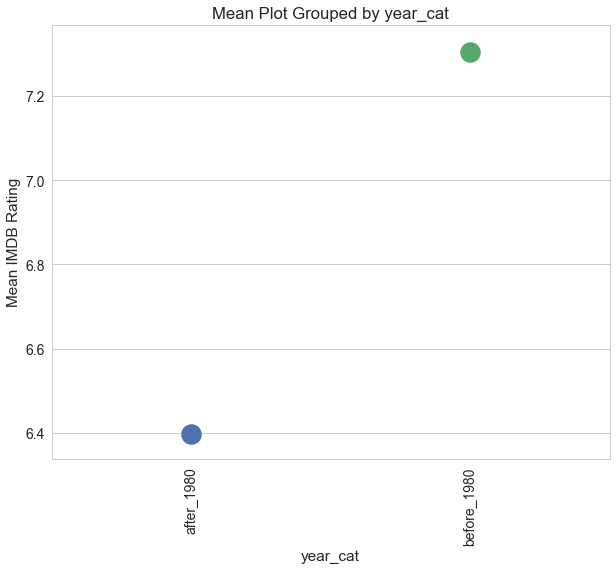

In [21]:
data_with_y['year_cat'] = data_with_y['title_year'].apply(year_category)
year_cat_df = subset_by_freq_value(data_with_y, 'year_cat')
cat_boxplot(year_cat_df, 'year_cat')
cat_meanplot(year_cat_df, 'year_cat')

##### 2.22 Number of Genres
Next, let's creat a **num_genres** feature from **genres**.

In [22]:
data_with_y['genres'].head(5)

0            Action|Adventure|Drama|Thriller
1                             Comedy|Romance
2                       Comedy|Drama|Romance
3                         Drama|Thriller|War
4    Fantasy|Mystery|Romance|Sci-Fi|Thriller
Name: genres, dtype: object

We can see that most movies belong to two to four categories:

In [23]:
data_with_y['num_genre'] = data_with_y['genres'].apply(num_genres)
data_with_y['num_genre'].value_counts()

3    1304
2    1075
4     786
1     508
5     282
6      60
7      15
8       4
Name: num_genre, dtype: int64

From the boxplot and meanplot below we see that movies with less genre numbers have a wider **imdb_score** distribution and the means are differnt across various **num_genre** groups.

PS: even though **num_genre** is a numerical feature, we can still use boxplot because the feature only takes on a few unique values.

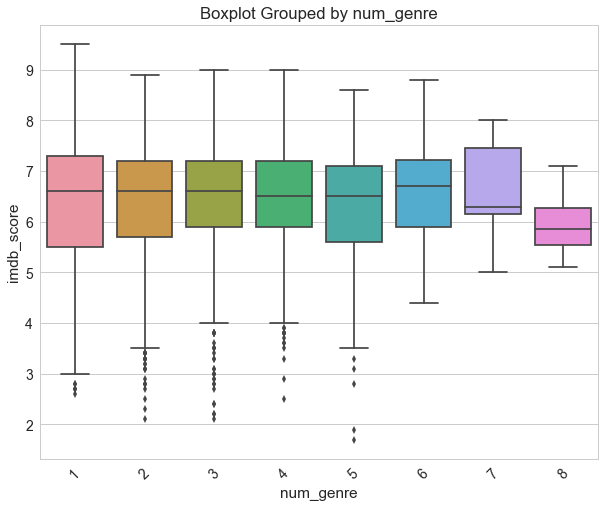

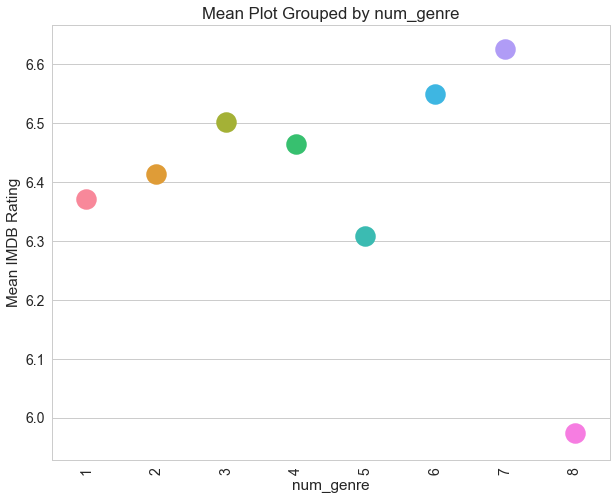

In [24]:
year_cat_df = subset_by_freq_value(data_with_y, 'num_genre')
cat_boxplot(year_cat_df, 'num_genre')
cat_meanplot(year_cat_df, 'num_genre')

##### 2.23 Content Rating

Let's create a **content_cat** feature that keep the most frequent attributes including "R", "PG-13", and "PG" and group others into "Other".

In [25]:
top_frequent_value(data_with_y, 'content_rating')

,content_rating,count
0,R,1721
1,PG-13,1167
2,PG,558
3,Not Rated,87
4,G,82
5,Unrated,52
6,Approved,42
7,TV-14,24
8,TV-MA,15
9,TV-PG,11


In [26]:
data_with_y['content_cat'] = data_with_y['content_rating'].apply(content_rating_cat)

### 3. Final Model

After all the exploratory data analysis and baseline modeling, we have finally come to the final modeling part! :)

In this section, we will do the following:
1. A model with all categorical and numerical features we have used and engineered so far
2. We then select the most important features and run another model
3. Fine-tune our best model to make it even better

#### 3.1 Model with Full Features
After using new features in the model we see that the RMSE dropped from 0.8114 to 0.4381 which is a significant improvement.

In [27]:
cat_features = ['year_cat', 'content_cat']
num_features = ['num_critic_for_reviews', 'duration', 'director_facebook_likes',
                'gross', 'num_voted_users', 'cast_total_facebook_likes',
                'num_user_for_reviews', 'budget', 'avg_director_name_score', 
                'avg_actor_1_name_score', 'num_genre']

# numerical feature pipeline
num_pipeline = Pipeline([('feature_selector', FeatureSelector(num_features)),
                         ('imputer', Imputer(strategy="median")),
                         ('feature_scaler', StandardScaler())])

# sklearn doesn't have a function that fill missing values for categorical features
# we need to use the fillna function from pandas here
data_with_y[cat_features] = data_with_y[cat_features].fillna(value='missing')

# categorical feature pipeline
cat_pipeline = Pipeline([('feature_selector', FeatureSelector(cat_features)),
                         ('one_hot_encoder', CategoricalEncoder(encoding='onehot-dense'))]) 

full_preprocess_pipeline = FeatureUnion(transformer_list =[('num_pipeline', num_pipeline), 
                                                           ('cat_pipeline', cat_pipeline)])

X_train_full = full_preprocess_pipeline.fit_transform(data_with_y)
xgboost_full_reg, xgboost_full_rmse = train_model(X_train_full, y_train, XGBRegressor())

print "XGBoost with full features RMSE: "
cross_validation_rmse(xgboost_full_reg, X_train_full, y_train)

XGBoost with full features RMSE: 
('RMSE from 10-fold cross validation:', array([ 0.44958992,  0.41458874,  0.42832496,  0.49165994,  0.44954819,
        0.43240006,  0.45953004,  0.45057724,  0.44415152,  0.39686196]))
('RMSE Mean:', 0.44172325798614853)
('RMSE Standard deviation:', 0.024563003756218296)



#### 3.2 Model with Most Importance Features

From the feature importance plot below we see that new features are truly very predictive, **avg_director_name_score** and **avg_actor_1_name_score** are the top 2 important features.

In [28]:
cat_encoder = cat_pipeline.named_steps["one_hot_encoder"]
cat_one_hot_features = list(cat_encoder.categories_[0]) + list(cat_encoder.categories_[1])
feature_list = num_features + cat_one_hot_features
xgb_feature_importance = xgboost_full_reg.booster().get_score(importance_type='gain').values()

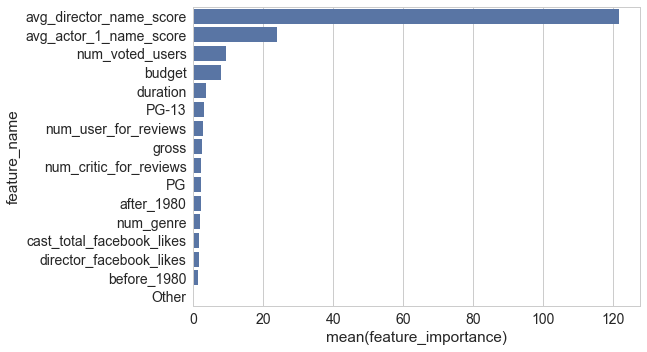

In [29]:
feature_importance_plot(xgb_feature_importance, feature_list[:len(xgb_feature_importance)])

Now the model has 17 features. It's not a large number but can we remove some redundant ones? The answer is yes! We can define a TopFeatureSelector class and use it in the pipeline. Here, I removed the 5 least most important features.

In [30]:
('Number of featreus in the model: ', len(X_train_full[0]))

('Number of featreus in the model: ', 17)

After training the model on the rest features, the RMSE changed from 0.4417 to 0.4412, we slightly improved the model performance.

In [31]:
final_pipeline = Pipeline([
    ('preparation', full_preprocess_pipeline),
    ('feature_selection', TopFeatureSelector(xgb_feature_importance, 12))
])

X_train_final = final_pipeline.fit_transform(data_with_y)
xgboost_reg, xgboost_rmse = train_model(X_train_final, y_train, XGBRegressor())

print "XGBoost with most important features RMSE: "
cross_validation_rmse(xgboost_reg, X_train_final, y_train)

XGBoost with most important features RMSE: 
('RMSE from 10-fold cross validation:', array([ 0.44765321,  0.41326995,  0.43087498,  0.49312831,  0.44961094,
        0.43300809,  0.4579884 ,  0.44964061,  0.4384804 ,  0.39813409]))
('RMSE Mean:', 0.44117889788056253)
('RMSE Standard deviation:', 0.024449737155891573)



#### 3.3 Fine-tune XGBoost

XGBoost is very powerful yet very complicated to tune. For a detailed intro on how to tune its hyperparameters, please refer to this link: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Here, we can use sklearn's GridSearchCV to tune the model. Given a dictionary of parameter names and candidate values, GridSearchCV will traverse through all possible combinations of values of parameters, then it trains the model using the best combination.

XGBoost has more than 10 parameters to tune, I used three of them as a demonstration.

In [32]:
param_distribs = {
        'learning_rate': [0.001, 0.1, 0.3],
        'n_estimators': [100, 300],
        'reg_alpha': [0, 0.1]
    }

clf = GridSearchCV(XGBRegressor(), param_distribs, cv=5,
                   scoring='neg_mean_squared_error')
clf.fit(X_train_final, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 300], 'learning_rate': [0.001, 0.1, 0.3], 'reg_alpha': [0, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

### 4. Productionize the Model

#### 4.1 Predict on Test Set

First, we need to create the new features for the test set.

In [33]:
X_test = pd.merge(X_test, director_avg_df, how='left', on=['director_name'])
X_test_prepared = pd.merge(X_test, actor1_avg_df, how='left', on=['actor_1_name'])

X_test_prepared['year_cat'] = X_test_prepared['title_year'].apply(year_category)
X_test_prepared['num_genre'] = X_test_prepared['genres'].apply(num_genres)
X_test_prepared['content_cat'] = X_test_prepared['content_rating'].apply(content_rating_cat)

In [34]:
X_test_prepared.head(5)

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,budget,title_year,actor_2_facebook_likes,aspect_ratio,movie_facebook_likes,avg_director_name_score,avg_actor_1_name_score,year_cat,num_genre,content_cat
0,Color,Sai Varadan,3.0,89.0,0.0,163.0,Hassan Johnson,196.0,NaN,Drama,...,125000.0,2014.0,180.0,NaN,72,NaN,NaN,after_1980,1,R
1,Color,Craig Gillespie,151.0,124.0,44.0,367.0,Suraj Sharma,4000.0,36447959.0,Biography|Drama|Sport,...,25000000.0,2014.0,774.0,2.39,10000,6.866667,5.833333,after_1980,3,PG
2,Color,James Mangold,125.0,123.0,446.0,821.0,Natasha Lyonne,20000.0,47095453.0,Comedy|Fantasy|Romance,...,48000000.0,2001.0,1000.0,1.85,0,7.100000,6.633333,after_1980,3,PG-13
3,Color,Jennifer Wynne Farmer,2.0,107.0,0.0,236.0,Akima,752.0,10508.0,Drama,...,700000.0,1998.0,282.0,NaN,102,NaN,NaN,after_1980,1,PG-13
4,Color,Dario Argento,76.0,120.0,930.0,433.0,Adrienne Barbeau,982.0,349618.0,Horror,...,9000000.0,1990.0,602.0,1.85,375,NaN,4.800000,after_1980,1,R


Using the pipeline, we can preprocess the tes tset with just one line of code.

In [35]:
X_test_final = final_pipeline.transform(X_test_prepared)

Now, let's predict on the test set. The RMSE is 0.9791 which means on average, our prediction is about 0.97 point off the actual movie rating of movies in the test set. Let's also save the predictions into a csv file.

In [36]:
y_test_pred = clf.predict(X_test_final)
print 'RMSE on test set is: ' + str(np.sqrt(mean_squared_error(y_test, y_test_pred)))
predict_df = pd.DataFrame({'movie_title': X_test['movie_title'], 'moving_rating':y_test, 'rating_prediction':y_test_pred})
predict_df.to_csv('IMDB_movie_rating_prediction.csv', index=None)
predict_df.head(10)

RMSE on test set is: 0.97912341142


,movie_title,moving_rating,rating_prediction
0,An American in Hollywood,7.2,6.722827
1,Million Dollar Arm,7.0,6.107563
2,Kate & Leopold,6.4,6.649538
3,Naturally Native,6.5,6.817553
4,Two Evil Eyes,6.1,5.900502
5,You Can't Take It with You,8.0,7.421243
6,Star Wars: Episode I - The Phantom Menace,6.5,7.424752
7,Pokémon 3: The Movie,5.6,6.676925
8,The Dead Zone,7.5,7.052846
9,The Wolverine,6.7,7.090773


#### 4.2 Save Model for Production

Finally, we are about to wrap up the end-to-end machine learning process! The last step is to save our model. Next time when we want to make predictions for a new movie, we can simply load and use our pre-trained model.

In [37]:
joblib.dump(clf, "imdb_model.pkl")
imdb_model = joblib.load("imdb_model.pkl")
imdb_model

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 300], 'learning_rate': [0.001, 0.1, 0.3], 'reg_alpha': [0, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

### 5. Final Discussion

#### 5.1 Potential Improvements

The RMSE on the test set is 0.9791. This is not a bad score, but certainly not a great one. This performance can be a result of the following reasons:
1. We don't have enough strong features. Most of the original numerical features have a low correlation with **imdb_score**. We can incorporate other data including:
    * User/critic reviews. We would get a better sense of how people perceive a movie using sentiment analysis
    * Moving rating from other websites, e.g. Rotten Tomato
    * Number of awards a movie has won
    * Type of awards a movie has won, e.g. Golden Globe and Oscar
2. We don't have enough data. If we have more data, the average **imdb_score** for director and actors could be more useful. In the current dataset lots of actors or directors only have one movie, the average score for them will just be the **imdb_score** of the movie. This will likely causes our model to overfit the data. It'd be more insightful if we can compute the average score for a person based on multiplie movies she/he is in

#### 5.2 Business Insights

What is the business implication of this project? Maybe in the future when a film studio is deciding on investing in a new movie they can take our model's prediction into consideration. We won't have the **gross** or **awards** data for the new movie yet. But average rating of director and actors can be helpful. Certainly, this can only happen when we have a rather robust model.